# 課題2. 移流拡散方程式（MonteCarlo法）

物質の密度分布$f = f(x, t)$を表す以下の移流拡散方程式
$$
\frac{\partial f}{\partial t} +
U \frac{\partial f}{\partial x} =
D \frac{\partial^2 f}{\partial x^2}
$$
は$f(x, t)$の速度$U$での移流および拡散係数$D$での拡散を表す方程式であり，多くの場面で登場する非常に重要な方程式である．  
ここではこの方程式を乱数を用いたモンテカルロ法によって解いてみよう．


ある粒子の位置$x$が時刻$\tau$ごとに等確率で$x + \Delta$もしくは$x - \Delta$に移動するとき，この粒子の運動をランダムウォーク(random walk)と呼ぶ．ランダムウォークの試行回数$n$を無限大とした極限$n \rightarrow \infty$で，粒子の存在確率分布$P(x)$が拡散方程式に従うことが示され，拡散係数は$D = \Delta^2 /(2 \tau)$によって与えられる．従って，ある時刻における物質の密度分布$f(x, t)$を有限個の粒子の重ね合わせで近似し，個々の粒子の運動をランダムウォークによって記述すれば得られる粒子の分布は拡散方程式の近似解を与える．移流項については全ての粒子について，一定の移動速度$U$の効果を加えればよい．  
なお，以下では$x$の範囲は無限空間($-\infty < x < \infty$)とし，$\lim_{x \rightarrow \pm \infty} f(x) = 0$なる境界条件を採用する．(要するに境界条件は考えなくてよいということである．)また，初期分布は $f(x, t=0) = \delta (x)$ とする．

以上の条件のもとで移流拡散方程式の数値解(時間発展)を求めよ．  
ただし，ランダムウォークによる拡散現象の近似はあくまで試行回数が多い場合の極限（中心極限定理）で成り立つことに注意しよう．すなわち，$\tau \ll 1$でなければ$t \sim O(1)$での解としては不適切である．  
特に，
(1) $U = 0$，$D = 1$，
(2) $U = 0.2$，$D = 1$,
(3) $U = 2.0$, $D = 1$
の場合について$t = 1, 2, 3, 4$での解を図示し，解析解と比較すること．  


### ヒント
- ある時刻の$f(x, t)$を有限個の粒子で近似するには，例えば$N$個の粒子を用いるならばプログラム中で各粒子の$x$座標を表す長さ$N$の配列を用意すればよい．初期条件がデルタ関数$f(x, 0) = \delta (x)$で与えられているため，初期に全ての粒子の$x$座標を0にしておけばよい．
- 時間発展の結果を図示する際には粒子の分布から適当なビン幅でヒストグラムを作成し，それを$f(x)$と考えればよい．ただし規格化(即ち$\int_{-\infty}^{\infty} f(x) = 1$)に注意せよ．ヒストグラムの作成には `np.histogram()` を用いればよい．
- ランダムウォークは乱数を用いて実装すればよい．即ち各粒子の位置$x_i (t) (i=1, 2, \ldots, N)$を時間ステップ$\tau$進めるには
$$
 x_i (t + \tau) = x_i (t) + U \tau \pm \sqrt{2 D \tau}
$$
とすればよい．ここで符号$\pm$を各ステップごと，各粒子ごとにランダムに選ぶ．すなわち，$[0, 1)$区間の一様乱数$r$を発生させ，$r < 0.5$の時には$+$，それ以外では$-$を選べばよい．

### 解析解
このときの解析解(Green関数)は
$$
 f(x, t) = \frac{1}{2 \sqrt{\pi D t}}
    \exp \left( - \frac{(x - U t)^2}{4 D t} \right)
$$
で与えられる．  

Text(0.5, 1.0, 'analytic solution')

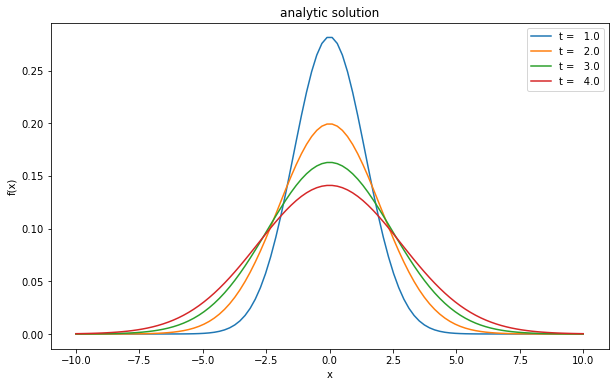

In [1]:
# 解析解の表示例
# 数値解を求めて同じプロット上に表示すること
import numpy as np
from matplotlib import pyplot as plt

fig  = plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')
t    = [1.0, 2.0, 3.0, 4.0]
x    = np.linspace(-10, +10, 100)
u    = 0.0
d    = 1.0

def analytic(t, x, u, d):
    "解析解"
    sigma = np.sqrt(2*d*t)
    xx = (x-u*t)/sigma
    return np.exp(-0.5*xx**2) / (np.sqrt(2*np.pi)*sigma)

for i in range(len(t)):
    f = analytic(t[i], x, u, d)
    l = 't = {:5.1f}'.format(t[i])
    plt.plot(x, f, color=cmap(i), linestyle='-', label=l)
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('analytic solution')

In [2]:
def push_step(p, u, d, delt, step):
    "粒子位置配列pをタイムステップdeltでstep数だけ更新"
    for i in range(step):
        r = 2*np.rint(np.random.rand(p.size)) - 1
        p[:] = p[:] + u*delt + np.sqrt(2*d*delt)*r

def integrate(p, u, d, delt, tmax, nout, **params):
    "粒子位置配列xを初期値として積分"
    # ビンの準備
    xmin = params.get('xmin', -10)
    xmax = params.get('xmax', +10)
    nbin = params.get('nbin', 50)
    binw = (xmax - xmin)/nbin
    bins = np.linspace(xmin, xmax, nbin+1)  # ビンの端点
    binc = 0.5*(bins[:-1] + bins[+1:])      # ビンの中央値
    # 積分の準備
    f = np.zeros((nout, nbin))
    t = np.zeros((nout,))
    x = binc
    ntot = int(tmax / delt)
    step = ntot // nout
    # 積分
    time = 0.0
    for i in range(nout):
        # 粒子位置を更新
        push_step(p, u, d, delt, step)
        time = time + delt*step
        # ヒストグラム作成
        w = np.ones_like(p) / (binw * p.size)
        f[i,:], _ = np.histogram(p, bins, weights=w)
        t[i] = time
        i = i + 1
    return t, x, f

Text(0.5, 1.0, '$U = 0.0, D = 1.0$')

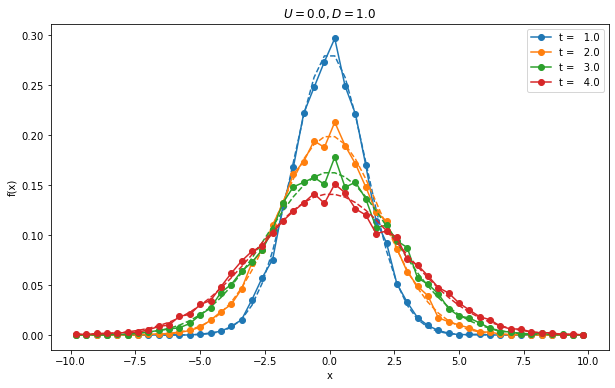

In [3]:
N    = 10000
p    = np.zeros((N,))
u    = 0.0
d    = 1.0
delt = 2.0e-4
tmax = 4.0
nout = 4
nbin = 50
xmin =-10.0
xmax =+10.0

# 積分
t, x, g = integrate(p, u, d, delt, tmax, nout, xmin=xmin, xmax=xmax, nbin=nbin)

# プロット
fig  = plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')

for i in range(nout):
    f = analytic(t[i], x, u, d)
    l = 't = {:5.1f}'.format(t[i])
    plt.plot(x, g[i,:], color=cmap(i), marker='o', linestyle='-', label=l)
    plt.plot(x, f, color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$U = {:3.1f}, D = {:3.1f}$'.format(u, d))

Text(0.5, 1.0, '$U = 0.2, D = 1.0$')

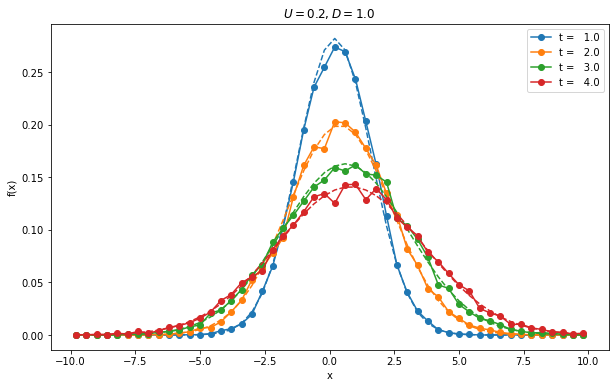

In [4]:
N    = 10000
p    = np.zeros((N,))
u    = 0.2
d    = 1.0
delt = 2.0e-4
tmax = 4.0
nout = 4
nbin = 50
xmin =-10.0
xmax =+10.0

# 積分
t, x, g = integrate(p, u, d, delt, tmax, nout, xmin=xmin, xmax=xmax, nbin=nbin)

# プロット
fig  = plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')

for i in range(nout):
    f = analytic(t[i], x, u, d)
    l = 't = {:5.1f}'.format(t[i])
    plt.plot(x, g[i,:], color=cmap(i), marker='o', linestyle='-', label=l)
    plt.plot(x, f, color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$U = {:3.1f}, D = {:3.1f}$'.format(u, d))

Text(0.5, 1.0, '$U = 2.0, D = 1.0$')

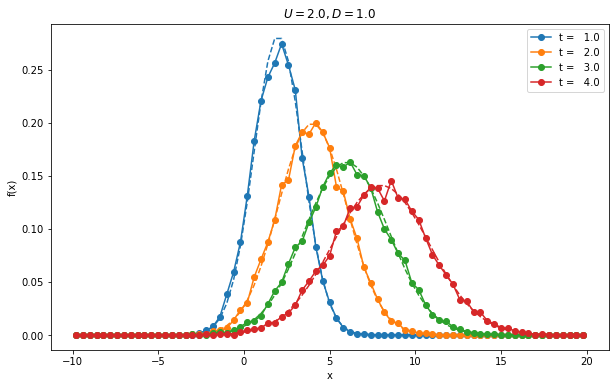

In [5]:
N    = 10000
p    = np.zeros((N,))
u    = 2.0
d    = 1.0
delt = 2.0e-4
tmax = 4.0
nout = 4
nbin = 75
xmin =-10.0
xmax =+20.0

# 積分
t, x, g = integrate(p, u, d, delt, tmax, nout, xmin=xmin, xmax=xmax, nbin=nbin)

# プロット
fig  = plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')

for i in range(nout):
    f = analytic(t[i], x, u, d)
    l = 't = {:5.1f}'.format(t[i])
    plt.plot(x, g[i,:], color=cmap(i), marker='o', linestyle='-', label=l)
    plt.plot(x, f, color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$U = {:3.1f}, D = {:3.1f}$'.format(u, d))

## 発展編

Green関数がガウシアンで与えられるため，実際には粒子の位置更新を
$$
 x_i (t + \tau) = x_i (t) + U \tau + \sigma dW
$$
のように行うことで定数の$U, D$に対しては任意の$\tau$で正しい解が得られる．ただし $\sigma = \sqrt{2 D \tau}$ ， $dW$ は正規乱数であり， `np.random.normal()` を用いて表すことができる．

このことを用いて，$U$や$D$が$x$の関数の場合の解も考えてみよう．  
ここでは$D(x) = D = {\rm const}$，
$$
U(x) =
\begin{cases}
    U_1 & x < 0 \\
    U_2 & x > 0
\end{cases}
$$
とし，このとき以下の移流拡散方程式
$$
\frac{\partial f}{\partial t} +
U \frac{\partial f}{\partial x} =
D \frac{\partial^2 f}{\partial x^2} + Q(x)
$$
の時間発展を求めよう．  
ただし，パラメータは$D = 1$，$U_1 = 4$，$U_2 = 1$，初期条件は$f(x, t=0) = 0$，ソース項として $Q(x) = \delta(x)$ とする．（これは$x = 0$において定常的に物質の注入があることを意味する．）

なお，十分時間がたった後 $(t = \infty)$ の定常解は解析解に
$$
f(x) =
\begin{cases}
  \displaystyle \frac{1}{U_1} \exp\left( \frac{U_1}{D} x \right) & x < 0 \\
  \displaystyle \frac{1}{U_1} & x > 0
\end{cases}
$$
で与えられる．  
また，簡単な考察から定常解に落ち着く時間スケールは $t \gg D/U_2^2 \sim 1$ 程度であることを示すことができる．  
従って数値解を$t = 10 D/U_2^2$程度まで求めて定常解に近づくことを確認すればよい．

### ヒント
定常な注入をプログラムで表現するには少し工夫が必要であるが，Green関数の考え方を用いると比較的簡単である．  
すなわち，初期に$x = 0$に配置された粒子分布の時間発展$G(x, t)$を求めることができれば，この解を用いて求めるべき分布は
$$
f(x, t) = \int G(x, t') dt' \approx \sum_{n} G(x, t^{n}) \Delta t
$$
のように時間積分することで求めることができるため，計算量を大幅に削減することが可能である．

なお，解の規格化には少し考察($f \rightarrow \infty$へのフラックスが$U_2/U_1$であることを用いればよい)が必要になるので，ここでは解の形状だけ合っていればよいものとする．

In [6]:
def push_step_advanced(p, u1, u2, d, delt, step, hist, bins):
    "粒子位置配列pを更新しながらヒストグラムを時間積分"
    binw = (bins[-1] - bins[0])/bins.size
    for i in range(step):
        r = np.random.normal(loc=0.0, scale=1.0, size=p.size)
        u = np.where(p<0, u1, u2)
        w = np.ones_like(p) / (binw * p.size) * delt * u2/u1
        p[:] = p[:] + u*delt + np.sqrt(2*d*delt)*r
        h, _ = np.histogram(p, bins, weights=w)
        hist[:] = hist[:] + h

def integrate_advanced(p, u1, u2, d, delt, tmax, nout, **params):
    "粒子位置配列xを初期値として積分しながらヒストグラムを時間積分"
    # ビンの準備
    xmin = params.get('xmin', -10)
    xmax = params.get('xmax', +10)
    nbin = params.get('nbin', 50)
    bins = np.linspace(xmin, xmax, nbin+1)  # ビンの端点
    binc = 0.5*(bins[:-1] + bins[+1:])      # ビンの中央値
    # 積分の準備
    f = np.zeros((nout, nbin))
    t = np.zeros((nout,))
    x = binc
    ntot = int(tmax / delt)
    step = ntot // nout
    # 積分
    i    = 0
    time = 0.0
    push_step_advanced(p, u1, u2, d, delt, step, f[0,:], bins)
    time = time + delt*step
    t[i] = time
    for i in range(1, nout):
        # 粒子位置を更新しながらヒストグラムを計算
        f[i,:] = f[i-1,:]
        push_step_advanced(p, u1, u2, d, delt, step, f[i,:], bins)
        time = time + delt*step
        t[i] = time
        i = i + 1
    return t, x, f

Text(0.5, 1.0, 'Advanced')

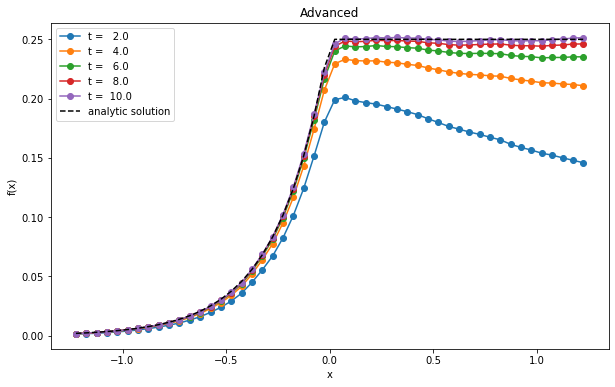

In [7]:
N    = 10000
p    = np.zeros((N,))
u1   = 4.0
u2   = 1.0
d    = 1.0
delt = 1.0e-3 * (d / u2**2)
tmax = 1.0e+1 * (d / u2**2)
nout = 5
nbin = 50
xmin =-5.0 * (d / u1)
xmax =+5.0 * (d / u1)

# 積分
t, x, g = integrate_advanced(p, u1, u2, d, delt, tmax, nout, xmin=xmin, xmax=xmax, nbin=nbin)

# プロット
fig  = plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')

# 解析解
f = np.where(x<0, np.exp(x*u1/d), 1.0) / u1

for i in range(nout):
    l = 't = {:5.1f}'.format(t[i])
    plt.plot(x, g[i,:], color=cmap(i), marker='o', linestyle='-', label=l)
plt.plot(x, f, 'k--', label='analytic solution')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Advanced')